In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image
import time

In [0]:
def load_img(path_to_img, max_dim):
  img = tf.io.read_file(filename = path_to_img)
  img = tf.image.decode_image(contents = img, channels = 3)
  img = tf.image.convert_image_dtype(image = img, dtype = tf.float32)
  img = tf.image.resize(images = img, size = (max_dim , max_dim), preserve_aspect_ratio = True)
  img = tf.expand_dims(img, 0)  
  return img

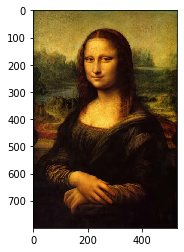

In [5]:
content_image = load_img("drive/My Drive/Projekt_2/ml", 800)
plt.imshow(content_image[0])

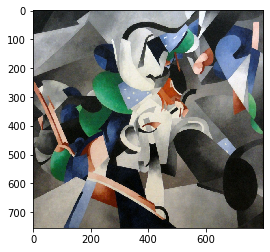

In [6]:
style_image = load_img("drive/My Drive/Projekt_2/st.jpg", 800)
plt.imshow(style_image[0])

In [0]:
print(tf.shape(content_image))
print(tf.shape(style_image))

tf.Tensor([  1 800 600   3], shape=(4,), dtype=int32)
tf.Tensor([  1 800 631   3], shape=(4,), dtype=int32)


In [0]:
vgg19 = tf.keras.applications.VGG19(include_top = True, weights = "imagenet")

574717952/574710816 [==============================] - 12s 0us/step


In [0]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
content_image_pp = tf.keras.applications.vgg19.preprocess_input(content_image*255)
content_image_rs = tf.image.resize(images = content_image_pp, size = (224 , 224))

In [0]:
prediction_probabilities = vgg19(content_image_rs)

In [0]:
predicted_top_10 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy(), top = 10)

40960/35363 [==================================] - 0s 0us/step


In [0]:
[(class_name, prob) for (number, class_name, prob) in predicted_top_10[0]]

[('palace', 0.9916597),
 ('triumphal_arch', 0.0025819347),
 ('monastery', 0.0012544608),
 ('library', 0.0010796455),
 ('fountain', 0.0008085539),
 ('church', 0.0004547465),
 ('cinema', 0.00032209442),
 ('castle', 0.00030228033),
 ('obelisk', 0.0002967426),
 ('bell_cote', 0.00021813068)]

In [0]:
style_image_pp = tf.keras.applications.vgg19.preprocess_input(style_image*255)
style_image_rs = tf.image.resize(images = style_image_pp, size = (224 , 224))
prediction_probabilities = vgg19(style_image_rs)
predicted_top_10 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy(), top = 10)
[(class_name, prob) for (number, class_name, prob) in predicted_top_10[0]]

[('jigsaw_puzzle', 0.1585181),
 ('prayer_rug', 0.11222482),
 ('shower_curtain', 0.09415095),
 ('pillow', 0.057611365),
 ('sarong', 0.043321356),
 ('quilt', 0.04086029),
 ('wool', 0.031667765),
 ('coral_reef', 0.028416542),
 ('cardigan', 0.026929578),
 ('book_jacket', 0.025868844)]

In [9]:
vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")

80142336/80134624 [==============================] - 2s 0us/step


In [0]:
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
content_layers = ["block5_conv2"]
style_layers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def vgg_layers(layer_names):
  lst = [vgg.get_layer(name = layer).output for layer in layer_names]
  return tf.keras.Model([vgg.input],lst)

In [0]:
vgg_layers(style_layers).output

[<tf.Tensor 'block1_conv1/Identity:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Identity:0' shape=(None, None, None, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Identity:0' shape=(None, None, None, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Identity:0' shape=(None, None, None, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1/Identity:0' shape=(None, None, None, 512) dtype=float32>]

In [0]:
def gram_matrix(input_tensor):
  res = tf.linalg.einsum('sijc,sijd->scd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  H_W = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return res/H_W

In [13]:
gram_matrix(vgg_layers(style_layers)(content_image)[0])

<tf.Tensor: id=730, shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.5478403 , 0.2780933 , 0.17148033, ..., 0.42295375,
         0.35227248, 0.3231732 ],
        [0.2780933 , 0.22123398, 0.14035547, ..., 0.11442003,
         0.18200551, 0.17069872],
        [0.17148033, 0.14035547, 0.09097299, ..., 0.06168472,
         0.1126905 , 0.1067342 ],
        ...,
        [0.42295375, 0.11442003, 0.06168472, ..., 0.4840687 ,
         0.27637598, 0.24328864],
        [0.35227248, 0.18200551, 0.1126905 , ..., 0.27637598,
         0.23487113, 0.21336238],
        [0.3231732 , 0.17069872, 0.1067342 , ..., 0.24328864,
         0.21336238, 0.1954047 ]]], dtype=float32)>

In [0]:
class StyleContentModel(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        inputs = inputs*255
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input) 
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content':content_dict, 'style':style_dict}

In [0]:
extractor = StyleContentModel(style_layers, content_layers)

In [0]:
style_targets = extractor(style_image)["style"]

In [17]:
style_targets["block1_conv1"]

<tf.Tensor: id=831, shape=(1, 64, 64), dtype=float32, numpy=
array([[[ 1036.133  ,   250.72043,   273.29025, ...,   638.88135,
           361.2416 ,   533.8303 ],
        [  250.72043,  1292.3173 ,   900.81146, ...,   363.35757,
           192.50204,   428.53802],
        [  273.29025,   900.81146,   796.86456, ...,   129.14345,
           218.3625 ,   492.81198],
        ...,
        [  638.88135,   363.35757,   129.14345, ..., 16328.829  ,
           394.8076 ,   134.67679],
        [  361.2416 ,   192.50204,   218.3625 , ...,   394.8076 ,
           541.4429 ,   505.68338],
        [  533.8303 ,   428.53802,   492.81198, ...,   134.67679,
           505.68338,   716.2648 ]]], dtype=float32)>

In [0]:
content_targets = extractor(content_image)["content"]

In [19]:
content_targets["block5_conv2"][0][0]

<tf.Tensor: id=1091, shape=(33, 512), dtype=float32, numpy=
array([[  0.       ,   0.       , 167.06804  , ...,   0.       ,
         63.813454 ,  38.89267  ],
       [  0.       ,   0.       ,  84.2096   , ...,   0.       ,
        132.09808  ,   6.5297484],
       [  0.       ,   0.       ,  46.85155  , ...,   0.       ,
        174.7414   ,   7.9566894],
       ...,
       [  0.       ,   0.       ,  27.189873 , ...,   0.       ,
          1.3205607,   0.       ],
       [  0.       ,   0.       , 104.92109  , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   9.842377 , ...,   0.       ,
         10.208699 ,   0.       ]], dtype=float32)>

In [0]:
image = tf.Variable(content_image)

In [0]:
content_weight, style_weight = 40.0, 100.0

In [0]:
opt = tf.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.99, epsilon = 1e-1)

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(t = image, clip_value_min = 0.0, clip_value_max = 1.0)

In [0]:
def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight,
                       num_style_layers, num_content_layers):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    style_loss = tf.add_n([tf.reduce_sum((style_outputs[name]-style_targets[name])**2) / tf.reduce_prod(tf.cast(tf.shape(style_outputs[name]), tf.float32)) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers / 4
    content_loss = tf.add_n([tf.reduce_sum((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers / 2
    loss = style_loss + content_loss
    return loss

In [0]:
@tf.function()
def train_step(extractor, image, style_targets, content_targets, style_weight, content_weight,
               num_style_layers, num_content_layers, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

In [0]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [0]:
start = time.time()
epochs = 500
steps_per_epoch = 10 
step = 14940
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(extractor, image, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers, opt)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [0]:
total_variation_weight = 100

In [0]:
@tf.function()
def train_step(extractor, image, style_targets, content_targets, style_weight, content_weight,
               num_style_layers, num_content_layers, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)
        loss += total_variation_weight*tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

In [0]:
image = tf.Variable(content_image)

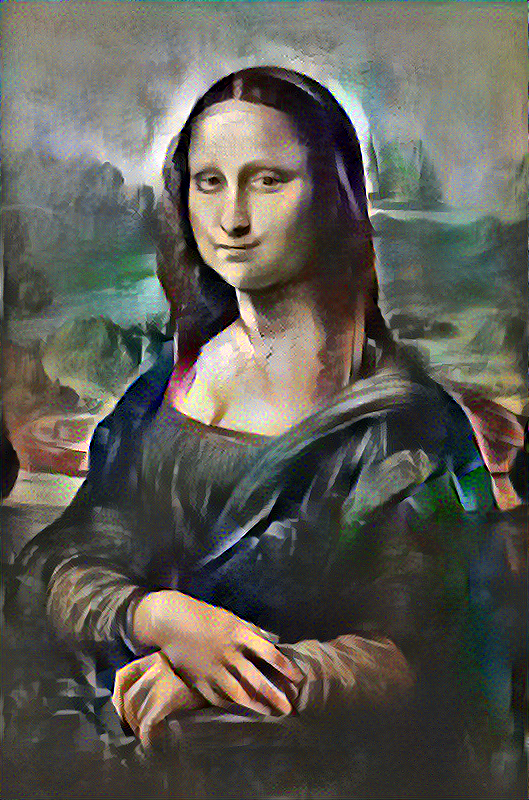

Train step: 100
Total time: 45.4


In [36]:
start = time.time()
epochs = 10
steps_per_epoch = 10 
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(extractor, image, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers, opt)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))

file_name = 'drive/My Drive/Projekt_2/ml_aa.png'
tensor_to_image(image).save(file_name)